In [1]:
# ========================================================
# TESTING2.ipynb — EV Price Prediction from Scratch
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore
import joblib
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded")

Libraries loaded


In [4]:
np.random.seed(42)
n = 500

brands = ["Tesla","BYD","Tata","MG","Hyundai","Kia","BMW","Audi","Mercedes","Porsche","Volkswagen","Ford"]
models = ["Model 3","Model Y","Nexon EV","ZS EV","Ioniq 5","EV6","i4","Q8 e-tron","EQS","Taycan","ID.4","Mach-E"]
body = ["Sedan","SUV","Hatchback"]
drive = ["FWD","RWD","AWD"]

df = pd.DataFrame({
    "brand": np.random.choice(brands, n),
    "model": np.random.choice(models, n),
    "battery_capacity_kwh": np.random.uniform(40, 110, n).round(1),
    "range_km": np.random.randint(250, 650, n),
    "top_speed_kmh": np.random.randint(140, 260, n),
    "acceleration_0_100_s": np.round(np.random.uniform(3.5, 9.0), 1),
    "seats": np.random.choice([4,5,7], n),
    "drivetrain": np.random.choice(drive, n),
    "car_body_type": np.random.choice(body, n),
    "fast_charging_power_kw_dc": np.random.choice([50,100,150,200], n),
    "cargo_volume_l": np.random.randint(300, 1700, n)
})

In [5]:
# ========================================================
# 2. ADD REALISTIC PRICE (INR)
# ========================================================

def base_price(b):
    b = b.lower()
    if b in ["tata","mg"]: return 12_00_000
    if b in ["hyundai","kia","byd"]: return 22_00_000
    if b in ["tesla","bmw","audi","mercedes"]: return 55_00_000
    if b in ["porsche"]: return 1_50_00_000
    return 35_00_000

df["price_inr"] = (
    df["battery_capacity_kwh"] * 13500 +
    df["range_km"] * 230 +
    df["brand"].apply(base_price) +
    (df["car_body_type"] == "SUV") * 200000 +
    np.random.randint(20000, 80000, n)
)
df["price_inr"] = (df["price_inr"] // 1000) * 1000

print("Sample data:")
display(df[["brand","model","battery_capacity_kwh","range_km","price_inr"]].head())

# Save dataset
df.to_csv("EV_dataset.csv", index=False)
print("EV_dataset.csv saved")

Sample data:


,brand,model,battery_capacity_kwh,range_km,price_inr
0,BMW,ZS EV,74.1,326,6799000.0
1,MG,Ioniq 5,99.6,261,2664000.0
2,Volkswagen,Mach-E,46.2,544,4320000.0
3,Audi,Taycan,96.4,473,6931000.0
4,Hyundai,Taycan,43.9,262,2888000.0


EV_dataset.csv saved


In [6]:
# ========================================================
# 3. PREPROCESSING
# ========================================================

X = df.drop(columns=["price_inr"])
y = df["price_inr"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scale', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# ========================================================
# 4. TRAIN 3 MODELS
# ========================================================

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGB": XGBRegressor(n_estimators=200, random_state=42, eval_metric='rmse')
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, pred)),
        "MAE": mean_absolute_error(y_test, pred),
        "R2": r2_score(y_test, pred)
    }
    print(f"{name} → RMSE: {results[name]['RMSE']:,.0f}")

# ========================================================
# 5. SAVE BEST MODEL
# ========================================================

best_name = min(results, key=lambda x: results[x]["RMSE"])
best_pipe = [p for n, p in [(n, Pipeline([('prep', preprocessor), ('model', m)]).fit(X_train, y_train)) for n, m in models.items()] if n == best_name][0]

joblib.dump(best_pipe, "price_prediction_model.pkl")
print(f"\nBest Model: {best_name}")
print("Model saved as: price_prediction_model.pkl")

Linear → RMSE: 18,272
RF → RMSE: 94,112
XGB → RMSE: 66,339

Best Model: Linear
Model saved as: price_prediction_model.pkl


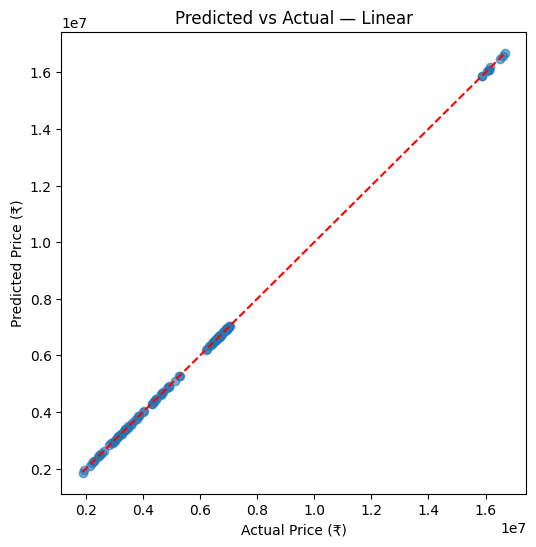

In [10]:
#@========================================================
# 6. PLOT RESULTS
# ========================================================

pred = best_pipe.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.title(f"Predicted vs Actual — {best_name}")
plt.show()

In [11]:

# ========================================================
# 7. SAVE PREDICTIONS
# ========================================================

pd.DataFrame({
    "actual": y_test.values,
    "predicted": pred.round(0)
}).to_csv("predictions_summary.csv", index=False)
print("predictions_summary.csv saved")

print("\nTESTING2.ipynb DONE!")
print("Next → Run: streamlit run ev_price_chatbot.py")

predictions_summary.csv saved

TESTING2.ipynb DONE!
Next → Run: streamlit run ev_price_chatbot.py
